In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
import scipy.stats as stats
import shutil
import os

pd.options.display.float_format = '{:.5f}'.format

In [15]:
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

In [16]:
src = "../data/"
dst = "../figures/"

In [17]:
# unzip data.zip if you havent
# if there is no data directory, then try to unzip data.zip
if not os.path.exists('../data'):
    shutil.unpack_archive('../data.zip', '../data')
    

In [18]:
with open(join(src, "./dtypes_config.pickle"), "rb") as file:
    DTYPES = pkl.load(file)

## COVARIATES PANEL

In [19]:
df_starters = pd.read_csv(join(src,
                      "discussions_starters_aggregates.csv"),
                 usecols=["Rating", "created_at",
                          "anger", "fear", "disgust", "sadness",
                          "joy", "pride", "hope"
                          ],
                          dtype=DTYPES)

len(df_starters)

9906260

In [20]:
# capitalize emotions
df_starters.columns = [col.capitalize() for col in df_starters.columns]

In [21]:
emotions = ["Anger", "Fear",
            "Disgust", "Sadness",
            "Joy", "Pride", "Hope"]

df_starters["Created_at"] = pd.to_datetime(df_starters["Created_at"])
df_starters["Day"] = df_starters["Created_at"].dt.date
df_starters["Week"] = df_starters["Created_at"].dt.to_period("W")

df_emotions_daily = df_starters.groupby("Day")[emotions].mean()

/tmp/ipykernel_1506923/4286943826.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_starters["Week"] = df_starters["Created_at"].dt.to_period("W")


In [22]:
df_weekly = df_emotions_daily.rolling(window=7).mean()
emotion_means = df_weekly.mean()
emotion_means

Anger     0.17968
Fear      0.03681
Disgust   0.01025
Sadness   0.01747
Joy       0.01516
Pride     0.00419
Hope      0.00404
dtype: float64

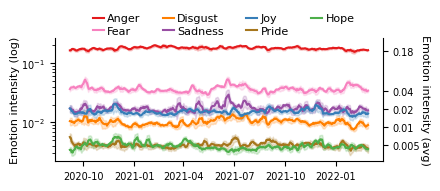

In [23]:
emotion_colormap = {
    "Anger": "#e41a1c",
    "Fear": "#f781bf",
    "Disgust": "#ff7f00",
    "Sadness": "#984ea3",
    "Joy": "#377eb8",
    "Pride": "#a6761d",
    "Hope": "#4daf4a"
}

std_error = df_emotions_daily.rolling(window=7).std() / np.sqrt(7)

ci_multiplier = 1.96 
df_ci_upper = df_weekly + ci_multiplier * std_error
df_ci_lower = df_weekly - ci_multiplier * std_error

fig, ax = plt.subplots(figsize=(4.5, 2))

df_weekly.plot(ax=ax, color=emotion_colormap, legend=False)
for emotion in emotions:
    ax.fill_between(df_weekly.index, df_ci_lower[emotion], df_ci_upper[emotion],
                    color=emotion_colormap[emotion], alpha=0.2)

ax2 = ax.twinx()
ax2.set_ylim(0,0.2)

# Now set the ticks at the emotion means
ax2.set_yticks([0.026,0.055,0.085,0.115,0.18])
# ax2.set_yticklabels(["0.1%", "1%", "2%", "4%", "18%"])
ax2.set_yticklabels([0.005,0.01,0.02,0.04,0.18])
ax2.set_ylabel("")
ax2.grid(False)
ax2.spines["right"].set_color("black")
ax2.spines["left"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_color("black")
ax2.tick_params(axis='y', labelsize=7)
ax2.set_ylabel("Emotion intensity (avg)", rotation=270, fontsize=8, labelpad=7)

ax.set_xlabel("", fontsize=8, labelpad=1)
ax.set_ylabel("Emotion intensity (log)", fontsize=8, labelpad=1)
ax.set_yscale("log")
ax.tick_params(axis="both", labelsize=7, bottom=True)


dates = pd.date_range(start=df_weekly.index.min(), 
                      end=df_weekly.index.max(), 
                      freq='3ME')  
ax.set_xticks(dates)
ax.set_xticklabels(dates.strftime('%Y-%m'))


ax.legend(loc='lower left', 
          bbox_to_anchor=(0.085, 0.94), 
          ncol=4,
          frameon=False,
          handlelength=1,
          handletextpad=0.3,
          labelspacing=0.2,
          fontsize=8)

ax.spines["left"].set_color("black")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.grid(False)
plt.tight_layout()
plt.savefig(join(dst, "emotions_over_time.pdf"), dpi=300)
plt.show()

In [24]:
df_discussions = pd.read_csv(
    join(src, "discussions_replies_aggregates.csv"),
    usecols=lambda col: col not in ['domain'],
    dtype=DTYPES
)

emotions = ["anger", "fear",
            "disgust", "sadness",
            "joy", "pride", "hope"]

df_discussions = df_discussions.rename(columns={emo: emo.capitalize() + "*" for emo in emotions})

df_discussions.columns

Index(['conversation_id', 'author_id', 'created_at', 'author.followers_count',
       'author.following_count', 'author.tweet_count', 'Rating', 'Anger*',
       'Fear*', 'Disgust*', 'Sadness*', 'Joy*', 'Pride*', 'Hope*',
       'Orientation', 'word_count', 'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'pride_log',
       'hope_log', 'anger_avg', 'fear_avg', 'disgust_avg', 'sadness_avg',
       'joy_avg', 'pride_avg', 'hope_avg', 'author.tweet_count_avg',
       'author.tweet_count_avg_log', 'time_diff', 'time_diff_log'],
      dtype='object')

In [25]:
selected_columns = [
    "Anger*", "Fear*", "Disgust*", "Sadness*",
    "Joy*", "Pride*", "Hope*", 
    "word_count_log",
    "time_diff_log",
    "author.tweet_count_log", "author.followers_count_log",
    "author.following_count_log", "anger_log", "fear_log", 
    "disgust_log", "sadness_log", "joy_log", "pride_log", "hope_log"
]
df_covariates = df_discussions[selected_columns]

df_covariates.columns = (
    df_covariates.columns
    .str.replace("author.followers_count_log", "Followers", regex=False) 
    .str.replace("author.following_count_log", "Following", regex=False)  
    .str.replace("author.tweet_count_log", "Tweet count", regex=False) 
    .str.replace("word_count_log", "Word count", regex=False)
    .str.capitalize() 
    .str.replace("Time_diff_log", "DTS", regex=False)
    .str.replace("_log", "")
)

df_covariates.columns

Index(['Anger*', 'Fear*', 'Disgust*', 'Sadness*', 'Joy*', 'Pride*', 'Hope*',
       'Word count', 'DTS', 'Tweet count', 'Followers', 'Following', 'Anger',
       'Fear', 'Disgust', 'Sadness', 'Joy', 'Pride', 'Hope'],
      dtype='object')

In [26]:
y_vars = ["Anger", "Fear", 
          "Disgust", "Sadness",
          "Joy", "Pride", "Hope",
          "Word count",
          "Tweet count", 
          "DTS",
          "Followers",
          "Following"]

x_vars = ["Anger*", "Fear*", "Disgust*", "Sadness*",
          "Joy*", "Pride*", "Hope*"]

corr = df_covariates[y_vars + x_vars].corr()

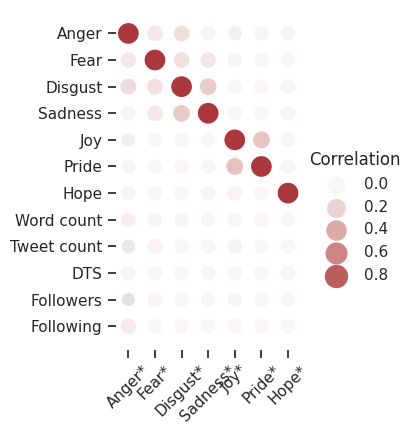

In [27]:
sns.set_theme(style="whitegrid")

corr_mat =corr.loc[x_vars, y_vars].stack().reset_index(name="Correlation")
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor="1",
    height=4.5, 
    aspect=4/4.5,
    sizes=(100, 250), 
    size_norm=(-.2, .8),
)

g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.08)
for label in g.ax.get_xticklabels():
    label.set_rotation(45)

emotions = ["Anger", "Fear",
            "Disgust", "Sadness",
            "Joy", "Pride", "Hope"]

custom_plots(ax=g.ax)
plt.tight_layout()
plt.savefig(join(dst, "covariates_correlation.pdf"), dpi=300)
plt.show()

In [30]:
barplot_map = ["#1b9e77", "#7570b3"]

# drop S as Rating
df_starters = df_starters[df_starters["Rating"] != "S"]

df_rating = df_starters\
    .groupby(["Week", "Rating"])\
        .size().unstack().fillna(0)

df_rating = df_rating.div(df_rating.sum(axis=1), axis=0)

# aggregate the average across time and the std
df_rating_agg = df_rating.agg(["mean", "std"]).T.round(3)

# multiply by 100 to get percentage
df_rating_agg = df_rating_agg * 100
df_rating_agg.index = ["Trustworthy", "Untrustworthy"]
df_rating_agg

,mean,std
Trustworthy,6.00000,0.60000
Untrustworthy,94.00000,0.60000


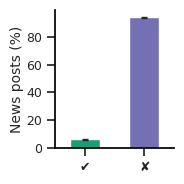

In [31]:
fig, ax = plt.subplots(figsize=(2, 2))
ax = df_rating_agg.plot(kind="bar", 
                   y="mean", yerr="std", 
                   color=barplot_map, 
                   capsize=2,
                   ax=ax)

# no legend
ax.legend().set_visible(False)
ax.set_xticklabels([u"\u2714",u"\u2718"], 
                        rotation=0,
                        fontsize=10)
ax.set_ylabel("News posts (%)", 
                   fontsize=10,
                   labelpad=1.5)
ax.tick_params(axis="both", labelsize=9)
custom_plots(ax=ax)
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position('left')
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## CAUSAL EFFECTS FIGURE

In [32]:
coeffs_dtypes = {
    "Coefficient": float, 
    "CI_Lower": float, 
    "CI_Upper": float
}

def process_coeffs(path, dtypes):
    df = pd.read_csv(path, dtype=dtypes)
    df["DV"] = df["DV"].str.replace("_avg", "").str.replace("_first", "")
    return df

replies_coeffs = process_coeffs("./replies/replies_coeffs.csv", coeffs_dtypes)
replies_coeffs_boot = process_coeffs("./replies/replies_res_boot.csv", coeffs_dtypes)
first_coeffs = process_coeffs("./replies/replies_first_coeffs.csv", coeffs_dtypes)
first_coeffs_boot = process_coeffs("./replies/replies_first_res_boot.csv", coeffs_dtypes)
same_coeffs = pd.read_csv("./replies/same_coeffs_emotions.csv",
                          dtype=coeffs_dtypes)


replies_coeffs['significant'] = replies_coeffs["P-Value"] < 0.05
first_coeffs['significant'] = first_coeffs["P-Value"] < 0.05
replies_coeffs

,DV,Coefficient,SE,CI_Lower,CI_Upper,P-Value,R-Squared,Cond_Mean,significant
0,Anger,0.03132,0.00243,0.02655,0.03608,0.00000,0.01552,0.36862,True
1,Disgust,0.00359,0.00058,0.00246,0.00472,0.00000,0.00565,0.01718,True
2,Fear,0.00185,0.00052,0.00082,0.00288,0.00042,0.00575,0.01503,True
3,Sadness,0.00092,0.00058,-0.00021,0.00206,0.10908,0.01328,0.01763,False
4,Joy,-0.00361,0.00087,-0.00531,-0.00191,0.00003,0.00808,0.03202,True
5,Pride,-0.00032,0.00026,-0.00083,0.00019,0.22073,0.00133,0.00527,False
6,Hope,-0.00008,0.00037,-0.00080,0.00063,0.81903,0.00157,0.00749,False


In [33]:
# take lower and upper percentile of the bootstrapped coefficients
def take_percentile(df):
    df_perc = df.groupby("DV")["Coefficient_boot"].quantile([0.025, 0.975]).unstack()
    df_perc.columns = ["CI_Lower_boot", "CI_Upper_boot"]
    df_perc = df_perc.reset_index()
    df['DV'] = df['DV'].astype(str)
    df_perc.columns = ["Emotion", "CI_Lower_boot", "CI_Upper_boot"]
    return df_perc

replies_boot_ci = take_percentile(replies_coeffs_boot)
first_boot_ci = take_percentile(first_coeffs_boot)
replies_boot_ci

,Emotion,CI_Lower_boot,CI_Upper_boot
0,Anger,0.02659,0.03608
1,Disgust,0.00247,0.00474
2,Fear,0.00084,0.00289
3,Hope,-0.00079,0.00063
4,Joy,-0.00532,-0.00190
5,Pride,-0.00084,0.00019
6,Sadness,-0.00020,0.00205


In [34]:
# standardize the column and dv names 
def standardize_names(df):
    df["DV"] = df["DV"].str.replace("_first", "").str.replace("_avg", "")
    df["DV"] = df["DV"].str.capitalize()
    df['DV'] = df['DV'].astype(str)
    df.rename(columns={"DV": "Emotion"}, inplace=True)
    return df

replies_coeffs = standardize_names(replies_coeffs)
first_coeffs = standardize_names(first_coeffs)

In [35]:
same_coeffs = same_coeffs.rename(
    columns={"Estimate": "Coefficient"})
same_coeffs

,Emotion,Coefficient,p,R2,Change,CI_Lower_boot,CI_Upper_boot
0,Anger,0.00881,0.46131,0.00011,2.43000,-0.01460,0.03262
1,Disgust,0.00730,0.01172,0.00123,44.25000,0.00149,0.01310
2,Fear,0.00731,0.00436,0.00158,59.19000,0.00220,0.01232
3,Sadness,-0.00279,0.34870,0.00017,-13.31000,-0.00851,0.00304
4,Joy,0.00154,0.72898,0.00002,4.73000,-0.00716,0.01033
5,Hope,-0.00135,0.42294,0.00012,-17.66000,-0.00469,0.00199
6,Pride,-0.00302,0.04463,0.00078,-39.45000,-0.00601,-0.00004


In [36]:
# add bootstrapped CI to the dataframes
replies_coeffs = replies_coeffs.merge(replies_boot_ci, on="Emotion")
first_coeffs = first_coeffs.merge(first_boot_ci, on="Emotion")

In [37]:
# sort according to Coefficient
replies_coeffs = replies_coeffs.sort_values("Coefficient")
first_coeffs = first_coeffs.sort_values("Coefficient")
same_coeffs = same_coeffs.sort_values("Coefficient")

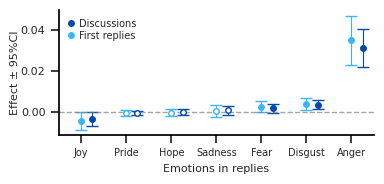

In [38]:
df_colormap = {
    "Discussions": "#004aad",
    "First replies": "#38b6ff"}

def plot_emotion_coefficients(ax, replies_coeffs, first_coeffs, 
                              df_colormap, 
                              custom_plots=None):
    
    emotion_categories = replies_coeffs["Emotion"].unique()
    emotion_positions = {emotion: i for i, emotion in enumerate(emotion_categories)}
    
    replies_coeffs = replies_coeffs.copy()
    first_coeffs = first_coeffs.copy()
    replies_coeffs["Emotion_Pos"] = replies_coeffs["Emotion"].map(emotion_positions)
    first_coeffs["Emotion_Pos"] = first_coeffs["Emotion"].map(emotion_positions)

    for i, row in replies_coeffs.iterrows():
        color = df_colormap["Discussions"] if row["significant"] else "white"
        ax.errorbar(row["Emotion_Pos"] + 0.25, 
                   row["Coefficient"],
                   yerr=row["CI_Upper_boot"] - row["CI_Lower_boot"],
                   fmt='o', 
                   color=color,
                   ecolor=df_colormap["Discussions"],
                   markeredgecolor=df_colormap["Discussions"],
                   markersize=4, elinewidth=0.8, capsize=4,
                   label="Discussions")

    for i, row in first_coeffs.iterrows():
        color = df_colormap["First replies"] if row["significant"] else "white"
        ax.errorbar(row["Emotion_Pos"], 
                   row["Coefficient"],
                   yerr=row["CI_Upper_boot"] - row["CI_Lower_boot"],
                   fmt='o', color=color,
                   ecolor=df_colormap["First replies"],
                   markeredgecolor=df_colormap["First replies"],
                   markersize=4, elinewidth=0.8, capsize=4,
                   label="First replies")
    
    
    ax.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.7)
    ax.set_ylabel("Effect ± 95%CI", fontsize=8, labelpad=0.5)  
    ax.set_xlabel("Emotions in replies", fontsize=8)
    ax.set_xticks(list(emotion_positions.values()))
    ax.set_xticklabels(emotion_categories, fontsize=7)
    ax.tick_params(axis="y", labelsize=8)
    ax.set_xlim(-0.5, len(emotion_categories) - 0.5)

    custom_plots(ax=ax)

    legend_handles = []
    
    discussions_marker = mlines.Line2D([], [], 
                                      color=df_colormap["Discussions"], 
                                      marker='o', markersize=6, 
                                      markeredgecolor="w", 
                                      linestyle="None", 
                                      label="Discussions")
    legend_handles.append(discussions_marker)
    
    first_replies_marker = mlines.Line2D([], [], 
                                        color=df_colormap["First replies"], 
                                        marker='o', markersize=6, 
                                        markeredgecolor="w", 
                                        linestyle="None", 
                                        label="First replies")
    legend_handles.append(first_replies_marker)
    
    
    ax.legend(handles=legend_handles, 
             loc="upper left", 
             fontsize=7, 
             frameon=False,
             handlelength=0.75,
             handletextpad=0.4, labelspacing=0.2)
    
    return ax

fig1, ax1 = plt.subplots(figsize=(4, 2))
plot_emotion_coefficients(ax1, replies_coeffs, first_coeffs, df_colormap,
                          custom_plots=custom_plots)

plt.tight_layout()

In [39]:
def import_means(dv):
    means = pd.read_csv(f"./engagement/{dv}_count_mfx.csv")\
                .reset_index()
    means = means.rename(columns={'index':'Rating'})
    means["DV"] = dv
    means["DV"] = means["DV"].str.capitalize()
    return means

like_means = import_means("like")
quote_means = import_means("quote")
reply_means = import_means("reply")
retweet_means = import_means("retweet")

means = pd.concat([like_means, 
                   quote_means, 
                   reply_means, 
                   retweet_means], 
                   ignore_index=True)
means.Rating = means.Rating\
                        .replace({0: "Trustworthy", 
                                  1: "Untrustworthy"})

# rename Like into Likes, etc.
means.DV = means.DV.replace({
    "Like": "Likes",
    "Quote": "Quotes",
    "Reply": "Replies",
    "Retweet": "Retweets"
})

means

,Rating,DV,Predicted,pLL,pUL
0,Trustworthy,Likes,5.23639,5.19135,5.27838
1,Untrustworthy,Likes,4.52638,4.48851,4.56333
2,Trustworthy,Quotes,0.19019,0.18823,0.19222
3,Untrustworthy,Quotes,0.21372,0.21153,0.21612
4,Trustworthy,Replies,0.71604,0.70997,0.72182
5,Untrustworthy,Replies,0.57638,0.57140,0.58128
6,Trustworthy,Retweets,1.43909,1.42717,1.45106
7,Untrustworthy,Retweets,2.00638,1.99121,2.02203


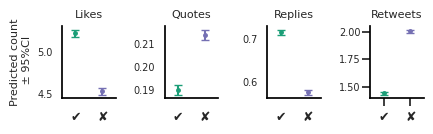

In [40]:
rating_cmap = {
    "Trustworthy": "#1b9e77",
    "Untrustworthy": "#7570b3"
}
def plot_engagement_means(ax, dv_data, dv_name, rating_cmap=None, 
                                 custom_plots=None, show_ylabel=True):
    
    for rating in dv_data["Rating"].unique():
        rating_data = dv_data[dv_data["Rating"] == rating]
        mean_val = rating_data["Predicted"].iloc[0]
        pll_val = rating_data["pLL"].iloc[0]
        pul_val = rating_data["pUL"].iloc[0]

        ax.errorbar(
            x=rating, 
            y=mean_val, 
            yerr=[[mean_val - pll_val], [pul_val - mean_val]],
            fmt="o-", 
            markersize=2.5, 
            capsize=3, 
            color=rating_cmap[rating],
            label=dv_name if rating == 0 else None
        )

    ax.set_xlabel("", fontsize=8)
    ax.set_ylabel("Predicted count\n ± 95%CI", fontsize=8) if show_ylabel else ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([u"\u2714", u"\u2718"], fontsize=9)
    ax.set_xlim(-0.5, 1.5)
    ax.yaxis.set_tick_params(pad=0.8)
    ax.set_title(dv_name, fontsize=8)
    
    custom_plots(ax=ax)
    
    return ax

fig, axs = plt.subplots(1, 4, figsize=(4.5, 1.5))
dv_list = ["Likes", "Quotes", "Replies", "Retweets"]
for i, dv in enumerate(dv_list):
    ax = axs[i]
    dv_data = means[means["DV"] == dv]
    plot_engagement_means(ax, dv_data, dv, rating_cmap=rating_cmap, 
                          custom_plots=custom_plots, show_ylabel=(i == 0))
plt.tight_layout()
plt.show()

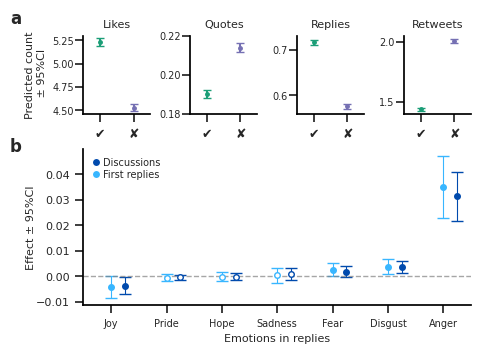

In [41]:
fig = plt.figure(figsize=(5, 3.5))
gs = fig.add_gridspec(2, 4, 
              figure=fig,
              height_ratios=[0.5, 1],
              width_ratios=[1, 1, 1, 1],
              wspace=0.6, 
              hspace=0.3)

# PLOT A: Engagement means for each DV
for i, dv in enumerate(["Likes", "Quotes", "Replies", "Retweets"]):
    ax1 = fig.add_subplot(gs[0, i])  
    dv_data = means[means["DV"] == dv]
    plot_engagement_means(ax1, dv_data, dv, 
                          rating_cmap=rating_cmap, 
                          custom_plots=custom_plots, 
                          show_ylabel=(i == 0))

    if dv == "Likes":
        ax1.set_ylim(ymin=4.46, ymax=5.3)
        ax1.set_yticks([4.5, 4.75, 5.0, 5.25])  
    elif dv == "Retweets":
        ax1.set_ylim(ymin=1.4, ymax=2.05)
        ax1.set_yticks([1.5, 2.0])  
    elif dv == "Replies":
        ax1.set_ylim(ymin=0.56, ymax=0.73)
        ax1.set_yticks([0.6, 0.7]) 
    else:
        ax1.set_ylim(ymin=0.18, ymax=0.22)
        ax1.set_yticks([0.18, 0.20, 0.22]) 

    ax1.set_title(dv, fontsize=8)
    custom_plots(ax=ax1)


# add titles
ax1.set_title("a", loc="left", 
              fontweight="bold",
              fontsize=12, x=-5.9, y=1.05)

# PLOT B: Emotion coefficients for replies and first replies
ax2 = fig.add_subplot(gs[1, :])  

plot_emotion_coefficients(ax2, replies_coeffs, first_coeffs, 
                          df_colormap,
                          custom_plots=custom_plots)

fig.text(-0.01, 0.55, "b", 
         fontweight="bold",
         ha="center", 
         fontsize=12)

plt.savefig(
    join(dst, "causal_effects.pdf"), 
        dpi=300,
        bbox_inches='tight')

plt.show()

## USER FIGURE

In [42]:
ratings = pd.read_csv(join("users/", "rating_coeffs.csv"))
ratings["Symbol"] = ratings["p"].apply(
    lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else ""
)
ratings['IV'] = 'Rating'
sig_ratings = ratings[ratings['p'] < 0.05].copy()
anger = ratings[ratings['DV'] == 'Anger'].copy()
fear = ratings[ratings['DV'] == 'Fear'].copy()
disgust = ratings[ratings['DV'] == 'Disgust'].copy()
joy = ratings[ratings['DV'] == 'Joy'].copy()
sig_ratings = pd.concat([anger, disgust, fear, joy], ignore_index=True)

all_sig_coeffs = pd.read_csv(join("users/","all_sig_coeffs.csv"))

all_sig_coeffs["IV"] = all_sig_coeffs["IV"]\
    .str.replace("author.", "")\
    .str.replace("_log", "")\
    .str.replace("_", " ")\
    .str.capitalize()\
    .replace("Followers count", "Followers")

all_sig_coeffs["Symbol"] = all_sig_coeffs["p"]\
    .apply(lambda x: "***" 
           if x < 0.001 else "**" 
           if x < 0.01 else "*" 
           if x < 0.05 else ""
)
merged_ratings = pd.concat([sig_ratings, all_sig_coeffs], ignore_index=True)
# drop duplicated rows
merged_ratings = merged_ratings.drop_duplicates()
# sort by DV
merged_ratings = merged_ratings.sort_values(by=["DV", "IV"])
merged_ratings

,DV,Estimate,SE,t,p,pLL,pUL,Symbol,IV
4,Anger,0.16520,0.02114,7.81267,0.00000,0.12628,0.20660,***,Anger
5,Anger,0.24107,0.09266,2.60157,0.00931,0.06686,0.41398,**,Disgust
8,Anger,-0.00871,0.00420,-2.07127,0.03843,-0.01667,-0.00097,*,Followers
7,Anger,-0.40791,0.18858,-2.16311,0.03058,-0.75811,-0.02887,*,Hope
0,Anger,0.01956,0.01309,1.49401,0.13527,-0.00574,0.04490,,Rating
6,Anger,0.19317,0.08412,2.29635,0.02170,0.03642,0.35386,*,Sadness
10,Disgust,0.06933,0.02263,3.06307,0.00220,0.03341,0.11757,**,Disgust
1,Disgust,0.00696,0.00320,2.17506,0.02970,0.00080,0.01313,*,Rating
11,Disgust,0.05546,0.02054,2.69928,0.00697,0.02349,0.10084,**,Sadness
13,Fear,0.04868,0.01284,3.79030,0.00015,0.02782,0.07695,***,Fear


In [44]:
df_replies = pd.read_csv(join(src, 
                            "discussions_replies.csv.gz"), 
                            compression='gzip',
                            usecols=[
                            'conversation_id', 'author_id', 
                            'author.tweet_count', 
                            'anger', 'fear', 'disgust', 
                            'Orientation']
                    )\
                .merge(df_discussions[["conversation_id", "Rating"]],
                            on='conversation_id', how='right')
len(df_replies), df_replies.conversation_id.nunique()

(11688608, 852206)

In [45]:
df_replies['Rating'] = df_replies['Rating'].astype(str)\
    .replace({'0.0':'Trustworthy', 
              '1.0':'Untrustworthy'})
df_replies.Rating.value_counts(dropna=False)

Rating
Trustworthy      11237196
Untrustworthy      451412
Name: count, dtype: int64

In [53]:
users_agg = pd.read_csv(join(src,
                            "all_users_aggregated.csv"),
                        usecols=[
                                'author_id', 'anger', 
                                'fear', 'disgust',
                                'Orientation'],
                         dtype={
                                'author_id': str,
                                'anger': float,
                                'fear': float,
                                'disgust': float,
                                'Orientation': str
                         })
users_agg

,author_id,anger,fear,disgust,Orientation
0,1000012,0.99599,0.00383,0.00454,NaN
1,1000017,0.44381,0.00137,0.00367,Neutral
2,1000023,0.01079,0.00077,0.00075,NaN
3,1000030,0.42607,0.00169,0.01271,Left
4,1000058,0.00815,0.00057,0.00059,NaN
...,...,...,...,...,...
397348,9999937,0.30733,0.00311,0.01077,Left
397349,9999946,0.27269,0.00283,0.00255,Neutral
397350,9999963,0.98642,0.00475,0.04839,NaN
397351,9999968,0.00062,0.00051,0.00102,NaN


In [54]:
def summarize_authors(df):
    n_replies = len(df)

    author_freq = df['author_id']\
                    .value_counts()\
                    .reset_index()\
                    .rename(columns={
                        'count': 'n_replies'})

    # calculate cumulative percentage
    author_freq = author_freq.sort_values('n_replies', 
                                          ascending=False)\
                             .reset_index(drop=True)
    author_freq['cum_replies'] = author_freq['n_replies'].cumsum()
    author_freq['cum_perc'] = author_freq['cum_replies'] / n_replies * 100
    author_freq['user_perc'] = (np.arange(len(author_freq)) + 1) / len(author_freq) * 100

    cutoff = np.argmax(author_freq["cum_perc"] >= 80)
    p_80 = author_freq.iloc[cutoff]["user_perc"]

    return author_freq, cutoff, p_80


total_users, total_cutoff, total_perc = summarize_authors(df_replies)

untrust_replies = df_replies[df_replies['Rating'] == 'Untrustworthy']
trust_replies = df_replies[df_replies['Rating'] == 'Trustworthy']

untrust_users, untrust_cutoff, untrust_perc = summarize_authors(untrust_replies)
trust_users, trust_cutoff, trust_perc = summarize_authors(trust_replies)

# extract the top users based on cutoff
untrust_users['author_id'] = untrust_users['author_id'].astype(str)
trust_users['author_id'] = trust_users['author_id'].astype(str)

top_untrust = untrust_users.iloc[:untrust_cutoff]\
                    .merge(users_agg, on="author_id", how="left")

top_trust = trust_users.iloc[:trust_cutoff]\
                    .merge(users_agg, on="author_id", how="left")

top_untrust["group"] = "Untrustworthy"
top_trust["group"] = "Trustworthy"
top_users = pd.concat([top_untrust, top_trust], ignore_index=True)
top_trust.author_id.nunique(), top_untrust.author_id.nunique()

(37583, 7803)

In [56]:
u_stat, p_value = stats.mannwhitneyu(top_trust["anger"].dropna(), 
                                        top_untrust["anger"].dropna(), 
                                        alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.3f}, p = {p_value:.5f}")

Mann-Whitney U test: U = 125151062.500, p = 0.00000


/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


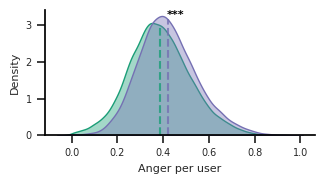

In [58]:
def plot_user_kde(ax, top_users):
    group_colors = {"Trustworthy": "#1b9e77", "Untrustworthy": "#7570b3"}
    stats_text = []

    for group, color in group_colors.items():
        rating_data = top_users[top_users['group'] == group]
        n_users = rating_data.author_id.nunique()
        group_data = top_users[top_users['group'] == group]["anger"].dropna()
        avg_value = group_data.mean()  

        sns.kdeplot(group_data, color=color, ax=ax, fill=True, alpha=0.4, label=group.capitalize())
        kde = gaussian_kde(group_data)
        density_at_mean = kde(avg_value)
        
        ax.vlines(avg_value, ymin=0, ymax=density_at_mean, color=color, 
                linestyle="--", linewidth=1.5, alpha=0.8)

        stats_text.append(f"{avg_value:.2f}, n={n_users}")

    ax.set_xlabel("Anger per user", fontsize=8)
    ax.set_ylabel("Density", fontsize=8)

    ax.tick_params(axis="both", 
                    which="major", 
                    labelsize=7)
    custom_plots(ax=ax)

fig, ax = plt.subplots(figsize=(3.5, 2))
plot_user_kde(ax, top_users)
ax.text(0.45, 1, "***", transform=ax.transAxes, fontsize=8, 
            fontweight='bold',
            verticalalignment='top', color="black")   
plt.tight_layout()
# plt.savefig(join(dst, "user_kde.pdf"), dpi=300)
plt.show()

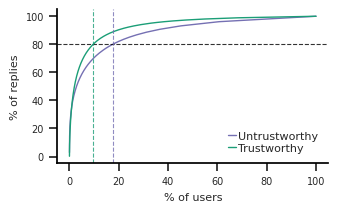

In [59]:
def plot_cdist(ax, untrust_users, trust_users, 
               untrust_perc, trust_perc):
    ax.plot(untrust_users["user_perc"], untrust_users["cum_perc"], 
            label="Untrustworthy", 
            color="#7570b3", 
            linewidth=1)  
    ax.plot(trust_users["user_perc"], trust_users["cum_perc"], 
            label="Trustworthy", 
            color="#1b9e77", 
            linewidth=1)

    ax.axhline(80, color="black", linestyle="--", 
                alpha=0.8, linewidth=0.8)
    ax.axvline(untrust_perc, color="#7570b3", 
                linestyle="--", alpha=0.8, linewidth=0.8)
    ax.axvline(trust_perc, color="#1b9e77", 
                linestyle="--", alpha=0.8, linewidth=0.8)

    ax.set_xlabel("% of users", fontsize=8)
    ax.set_ylabel("% of replies", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.legend(fontsize=8, frameon=False, 
            handlelength=0.75,
                handletextpad=0.2, labelspacing=0.2)
    
    custom_plots(ax=ax)
    return ax

fig, ax = plt.subplots(figsize=(3.5, 2))
plot_cdist(ax, untrust_users, trust_users,
           untrust_perc, trust_perc)
plt.show()

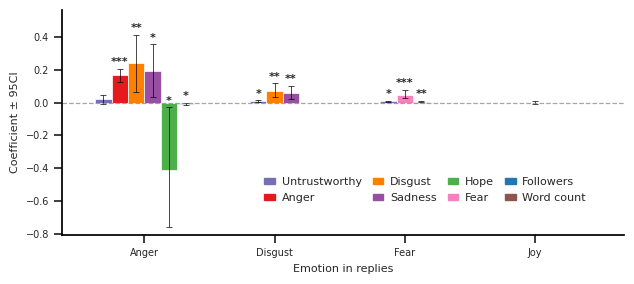

In [60]:
# rename rating to trustworthiness
merged_ratings['IV'] = merged_ratings['IV'].replace({'Rating': 'Untrustworthy'})


def plot_coeffs_as_bars(ax, custom_plots=None):

    category_colors = {
        'Untrustworthy': '#7570b3',
        'Anger': "#e41a1c",
        'Disgust': "#ff7f00", 
        'Sadness': "#984ea3", 
        'Hope': "#4daf4a",
        'Fear': "#f781bf",
        'Followers': "#1f77b4",
        'Word count': '#8c564b' 
    }

    legend_order = ['Untrustworthy', 
                    'Anger', 'Disgust', 'Sadness', 'Hope', 'Fear', 
                    'Followers', 'Word count']
    
    ivs = [iv for iv in legend_order if iv in merged_ratings['IV'].unique()]
    dvs = merged_ratings['DV'].unique()

    n_ivs = len(ivs)
    n_dvs = len(dvs)
    bar_width = 0.7 / n_ivs 
    dv_positions = np.arange(n_dvs)*0.95
    
    # Calculate how many non-NA bars exist for each DV to adjust bar width and positioning
    for dv_idx, dv in enumerate(dvs):
        # Count how many IVs have data for this DV
        n_bars_for_dv = sum(1 for iv in ivs if len(merged_ratings[(merged_ratings['IV'] == iv) & (merged_ratings['DV'] == dv)]) > 0)
        
        if n_bars_for_dv == 0:
            continue
            
        bar_width = 0.12
        bar_index = 0  # Track actual bar position (skipping NAs)
        
        for iv in ivs:
            iv_data = merged_ratings[(merged_ratings['IV'] == iv) & (merged_ratings['DV'] == dv)]
            
            if len(iv_data) == 0:
                continue  # Skip this IV for this DV entirely
            
            row = iv_data.iloc[0]
            estimate = row['Estimate']
            
            if 'pLL' in row and 'pUL' in row and pd.notna(row['pLL']) and pd.notna(row['pUL']):
                error_lower = estimate - row['pLL']
                error_upper = row['pUL'] - estimate
            else:
                error_lower = 0
                error_upper = 0
            
            # Position bar based on actual bar index (skipping NAs)
            x_position = dv_positions[dv_idx] + (bar_index - n_bars_for_dv/2 + 0.5) * bar_width
            color = category_colors.get(iv, '#808080')
            
            ax.bar(x_position, estimate, 
                   width=bar_width, 
                   linewidth=0.5,
                  color=color)
            
            yerr = [[error_lower], [error_upper]]
            ax.errorbar(x_position, estimate, yerr=yerr, fmt='none', 
                       color='black', capsize=2, capthick=0.5, linewidth=0.5)
            
            if 'Symbol' in row and pd.notna(row['Symbol']) and row['Symbol'] != '':
                symbol_y = estimate + error_upper + 0.01
                ax.text(x_position, symbol_y, row['Symbol'],
                       fontweight='bold', ha='center', va='bottom', fontsize=8)
            
            bar_index += 1  # Increment only when we actually draw a bar
    
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.9, alpha=0.7)
    
    ax.set_xticks(dv_positions)
    ax.set_xticklabels(dvs, fontsize=7)

    all_estimates = merged_ratings['Estimate'].values
    if 'pLL' in merged_ratings.columns and 'pUL' in merged_ratings.columns:
        y_min = min(merged_ratings['pLL'].min(), all_estimates.min()) - 0.05
        y_max = max(merged_ratings['pUL'].max(), all_estimates.max()) + 0.15  # Extra space for symbols
    else:
        y_min = all_estimates.min() - 0.05
        y_max = all_estimates.max() + 0.15
    
    ax.set_ylim(y_min, y_max)

    ax.set_ylabel('Coefficient ± 95CI', fontsize=8)
    ax.set_xlabel('Emotion in replies', fontsize=8)
    ax.set_xlim(-0.6, len(dvs) - 0.5)
    ax.tick_params(axis='y', labelsize=7)

    legend_order = ['Untrustworthy', 
                    'Anger', 'Disgust', 'Sadness', 'Hope', 'Fear', 
                    'Followers', 'Word count']
    handles = []
    labels = []
    for iv in legend_order:
        if iv in ivs:  # Only include variables that exist in the data
            color = category_colors.get(iv, '#808080')
            handles.append(plt.Rectangle((0,0),1,1, 
                                         color=color))
            labels.append(iv)
    
    ax.legend(handles, labels, 
              loc='lower right', 
              # manual placement
              bbox_to_anchor=(0.95, 0.1),
              ncols=4,
              fontsize=8, 
              columnspacing=1,
              handletextpad=0.6,
              handlelength=0.95,
              handleheight=0.5,
              frameon=False)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axisbelow(True)
    custom_plots(ax)
    
    return ax

fig, ax = plt.subplots(figsize=(6.5, 3))
plot_coeffs_as_bars(ax, custom_plots=custom_plots)
plt.tight_layout()
plt.show()

/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


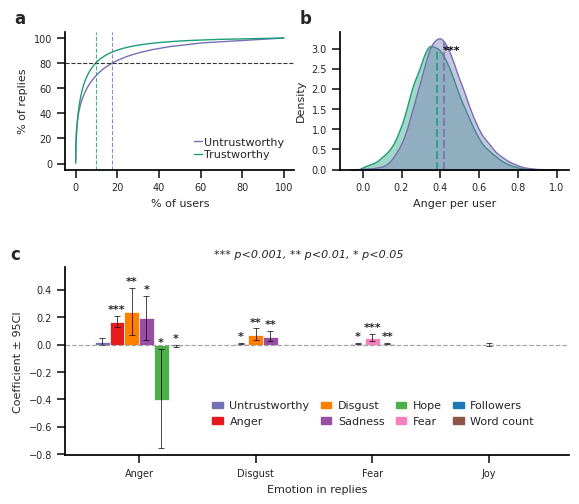

In [61]:
fig = plt.figure(figsize=(6.5, 5.5))

gs = fig.add_gridspec(2, 2, 
                      width_ratios=[1, 1], 
                      height_ratios=[0.55, 0.75],
                      hspace=0.6,
                      wspace=0.2
                      )

# Panel A: Same responder coefficients
ax1 = fig.add_subplot(gs[1, :])
plot_coeffs_as_bars(ax1, custom_plots=custom_plots)

ax1.set_title(label='c', x=-0.10, y=1, fontsize=12, 
              fontweight='bold')

# Panel B. Cumulative plots 
ax2 = fig.add_subplot(gs[0, 0])

plot_cdist(ax2, untrust_users, trust_users,
           untrust_perc, trust_perc)

ax2.set_title(label='a', x=-0.2, y=1, fontsize=12, 
              fontweight='bold')

# Panel C: KDE plots
ax3 = fig.add_subplot(gs[0, 1])

plot_user_kde(ax3, top_users)
ax3.text(0.45, 0.9, "***",
        transform=ax3.transAxes, 
        fontsize=8, 
        fontweight='bold',
        verticalalignment='top', 
        color="black")   

ax3.set_title('b', 
                x=-0.15, y=1, 
                fontsize=12,
                fontweight='bold')


plt.figtext(0.5, 0.47, 
                '*** p<0.001, ** p<0.01, * p<0.05', 
                ha='center', 
                fontsize=8, 
                style='italic')
plt.savefig(
    join(dst, "selection_effects.pdf"), 
        dpi=300,
        bbox_inches='tight')

plt.show()